In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall -y torch
!pip install torch==2.5.1+cu121 --index-url https://download.pytorch.org/whl/cu121


In [ ]:

# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install open3d
import open3d as o3d
from torch_geometric.io import read_ply
# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torch_geometric.datasets import ModelNet
from torch_geometric.transforms import SamplePoints, FixedPoints

!pip install open3d
!pip install numpy
import numpy as np
import torch
import pandas as pd
import os
from torch_geometric.data import Data, Dataset
from sklearn.preprocessing import MinMaxScaler


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.5 MB/s eta 0:00:00


In [ ]:
import torch

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: Tesla T4 is available.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import PointTransformerConv, global_max_pool
from torch_cluster import knn
import torch_scatter
print(torch_scatter.__version__)




class PointTransformer(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=1):
        super(PointTransformer, self).__init__()

        self.conv1 = PointTransformerConv(input_dim, hidden_dim)
        self.conv2 = PointTransformerConv(hidden_dim, hidden_dim*2)
        self.conv3 = PointTransformerConv(hidden_dim*2, hidden_dim)

        self.fc1 = nn.Linear(hidden_dim, 128)

        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x,pos, batch):
        edge_index = knn_graph(pos, k=8, batch=batch, loop=True)

        x = self.conv1(x=x,pos=pos, edge_index=edge_index)
        x = F.relu(x)
        x = self.conv2(x=x,pos=pos, edge_index=edge_index)
        x = F.relu(x)


        x = self.conv3(x=x,pos=pos, edge_index=edge_index)
        x = F.relu(x)
        x = global_max_pool(x, batch)


        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

model = PointTransformer()
print(model)


2.1.2+pt25cu121
PointTransformer(
  (conv1): PointTransformerConv(3, 128)
  (conv2): PointTransformerConv(128, 256)
  (conv3): PointTransformerConv(256, 128)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
def min_max_normalization(point_cloud, min_val=0, max_val=1):
    min_coords = point_cloud.min(axis=0)
    max_coords = point_cloud.max(axis=0)

    # Evitar divisão por zero (quando todos os pontos são iguais)
    scale = max_coords - min_coords
    scale[scale == 0] = 1.0

    normalized_cloud = (point_cloud - min_coords) / scale
    normalized_cloud = normalized_cloud * (max_val - min_val) + min_val
    return normalized_cloud

In [ ]:
class EggShellDatasetFeature(Dataset):
    def __init__(self, csv_file, root_dir, target_column, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        self.target_column = target_column
        self.measurements = self.data_frame.iloc[:, 1:].astype('float')

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ply_name = self.data_frame.iloc[idx, 0]
        ply_path = os.path.join(self.root_dir, ply_name)
        data = o3d.io.read_point_cloud(ply_path)
        normalized_point_cloud = min_max_normalization(np.asarray(data.points))

        # Features auxiliares
        features = torch.tensor([
            self.data_frame.iloc[idx][5],  # B
            self.data_frame.iloc[idx][1],  # B
            self.data_frame.iloc[idx][7],  # B

        ], dtype=torch.float)

        # Criar tensores
        pos = torch.tensor(normalized_point_cloud, dtype=torch.float)  # (N, 3)
        x = features.repeat(normalized_point_cloud.shape[0], 1)  # (N, F)

        # Mudar para VOL_ovo e Superficie para testar outras colunas
        cols = ['B','L']
        target_value = self.measurements.iloc[idx][cols]

        y = torch.tensor([target_value], dtype=torch.float)

        sample = Data(x=x,pos=pos, y=y.squeeze(1))
        # sample = Data(x=x,pos=pos, y=y.unsqueeze(0))

        if self.transform:
            sample = self.transform(sample)

        return sample


In [ ]:
data = EggShellDatasetFeature(csv_file='/content/drive/MyDrive/Eggshell Dataset Completo/Treino_Menor.csv', root_dir='/content/drive/MyDrive/Eggshell Dataset Completo/ovos3/', target_column='L')
data[0].x


tensor([[44.3102, 58.6107,  3.0000],
        [44.3102, 58.6107,  3.0000],
        [44.3102, 58.6107,  3.0000],
        ...,
        [44.3102, 58.6107,  3.0000],
        [44.3102, 58.6107,  3.0000],
        [44.3102, 58.6107,  3.0000]])

In [ ]:
class EggShellDatasetTargetSpecific(Dataset):
    def __init__(self, csv_file, root_dir, target_column, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        self.target_column = target_column
        self.measurements = self.data_frame.iloc[:, 1:].astype('float')

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ply_name = self.data_frame.iloc[idx, 0]
        ply_path = os.path.join(self.root_dir, ply_name)
        data = o3d.io.read_point_cloud(ply_path)

        # Carregar a nuvem de pontos
        normalized_point_cloud = min_max_normalization(np.asarray(data.points))
        pos = torch.tensor(normalized_point_cloud, dtype=torch.float)

        # Obtenha o alvo específico
        target_value = self.measurements.iloc[idx][self.target_column]
        y = torch.tensor([target_value], dtype=torch.float)

        sample = Data(pos=pos, y=y.unsqueeze(0))

        if self.transform:
            sample = self.transform(sample)

        return sample


In [ ]:
def train_target_model(target_column, train_csv, root_dir, model_class, num_epochs=20):
    # Criar datasets para o alvo específico
    transform = FixedPoints(num=2048)

    train_dataset = EggShellDatasetFeature(
    csv_file=train_csv, root_dir=root_dir, target_column=target_column,transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
    # Instanciar o modelo
    model = model_class()
    model.to(device)

    # Configurar otimizador e critério
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = torch.nn.MSELoss()

    # Loop de treino
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in train_loader:
          data.x = data.x.to(device)  # Features auxiliares (coordenadas + outras métricas)

          data.pos = data.pos.to(device)
          data.batch = data.batch.to(device)
          data.y = data.y.to(device)
          # batch.edge_index = knn_graph(batch.pos, k=8, batch=batch.batch).to(device)


          optimizer.zero_grad()
          output = model(data.x,data.pos, data.batch)

          loss = criterion(output, data.y)
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * data.num_graphs

        total_loss = running_loss / len(train_loader.dataset)
        train_losses.append(total_loss)
        print(f'Target: {target_column}, Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss}')

    return model, train_losses


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
import torch.optim as optim
from torch_geometric.loader import DataLoader
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import torch
from torch_cluster import knn_graph

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch_geometric")
warnings.simplefilter(action='ignore', category=FutureWarning)


trained_models = {}
# target = 'VOL_OVO'
model, losses = train_target_model(
        target_column=target,
        train_csv="/content/drive/MyDrive/Eggshell Dataset Completo/Treino_Menor_Completo.csv",
        root_dir='/content/drive/MyDrive/Eggshell Dataset Completo/ovos3/',
        model_class=PointTransformer,
        num_epochs=50
    )
trained_models[target] = model

In [ ]:
def test_target_model(model, test_loader, test_dataset):
    model.eval()
    running_test_loss = 0.0
    y_true_list = []
    y_pred_list = []
    criterion = torch.nn.MSELoss()

    with torch.no_grad():
        for data in test_loader:
            data.x = data.x.to(device)
            data.pos = data.pos.to(device)
            data.batch = data.batch.to(device)
            data.y = data.y.to(device)


            outputs = model(data.x,data.pos, data.batch)
            test_loss = criterion(outputs, data.y)
            running_test_loss += test_loss.item() * data.num_graphs
            print(outputs[0])

            y_real = data.y.cpu().numpy()
            y_pred_real = outputs.cpu().numpy()

            # mean_values = test_dataset.mean_values.to_numpy()
            # std_values = test_dataset.std_values.to_numpy()

            y_true_list.append(y_real)
            y_pred_list.append(y_pred_real)
        print("Valores reais:", y_real[:1])
        print("Valores previstos:", y_pred_real[:1])

    total_test_loss = running_test_loss / len(test_loader.dataset)
    return total_test_loss, y_true_list, y_pred_list


In [ ]:
transform = FixedPoints(num=2048)
test_dataset = EggShellDatasetFeature(
    csv_file="/content/drive/MyDrive/Eggshell Dataset Completo/Teste_Menor_Completo.csv", root_dir='/content/drive/MyDrive/Eggshell Dataset Completo/ovos3/', target_column=target, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=5)
loss, y_true, y_pred = test_target_model(trained_models[target]
, test_loader, test_dataset)

print(loss)


ValueError: could not convert string to float: '66,18'

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
y_pred = np.concatenate([batch.flatten() for batch in y_pred])

# Garantindo que y_true tenha o formato correto
y_true = np.concatenate([batch.flatten() for batch in y_true])

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Métricas do modelo:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")


In [ ]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico de dispersão e o histograma de erro
def plot_predictions_vs_actuals(y_true, y_pred):
    # Gráfico de dispersão
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previstos')
    plt.title('Gráfico de Dispersão: Previstos vs Reais')

    # Histograma de erro
    erros = (y_true - y_pred).flatten()  # Garante que seja 1D
    plt.subplot(1, 2, 2)
    plt.hist(erros, bins=20, edgecolor='black')
    plt.xlabel('Erro (Valor Real - Valor Previsto)')
    plt.ylabel('Frequência')
    plt.title('Histograma de Erro')

    plt.tight_layout()
    plt.show()

def plot_relative_errors(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      relative_error = (y_true - y_pred)
      plt.figure(figsize=(8, 5))
      plt.hist(relative_error, bins=30, edgecolor='black')
      plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Erro = 0')
      plt.xlabel('Erro Relativo (%)')
      plt.ylabel('Frequência')
      plt.title('Histograma de Erro Relativo')
      plt.legend()
      plt.show()


plot_predictions_vs_actuals(y_true, y_pred)
plot_relative_errors(y_true, y_pred)


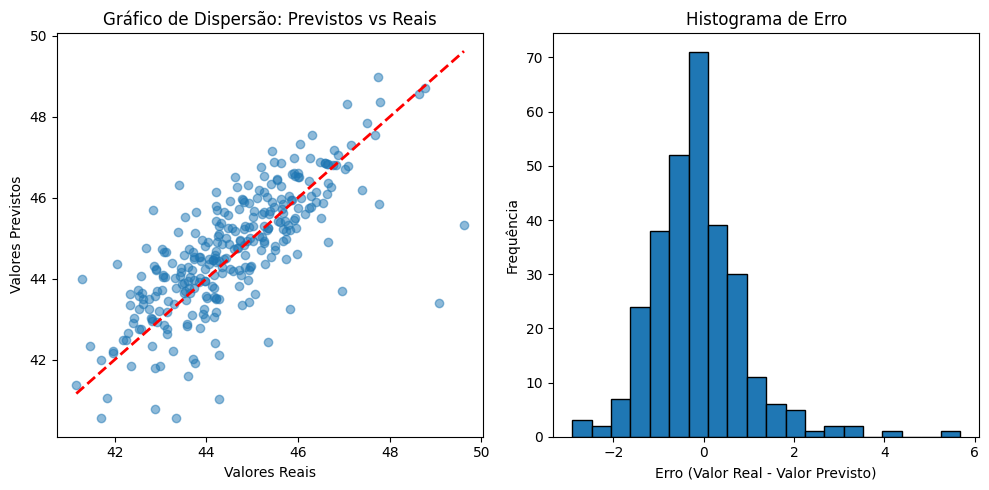

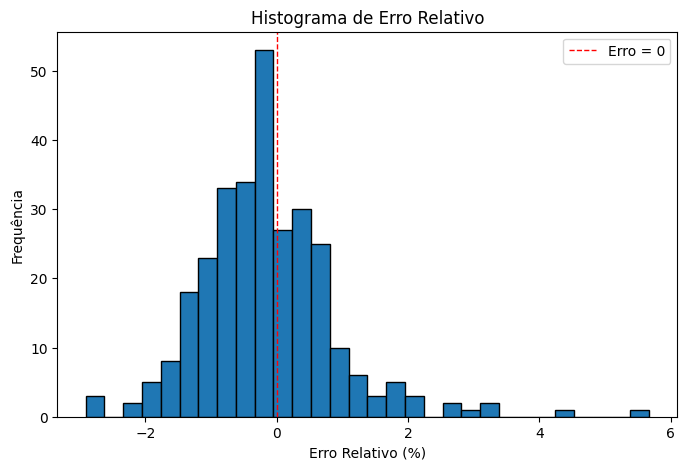

In [ ]:
plot_predictions_vs_actuals(b_real, b_pred)
plot_relative_errors(b_real, b_pred)

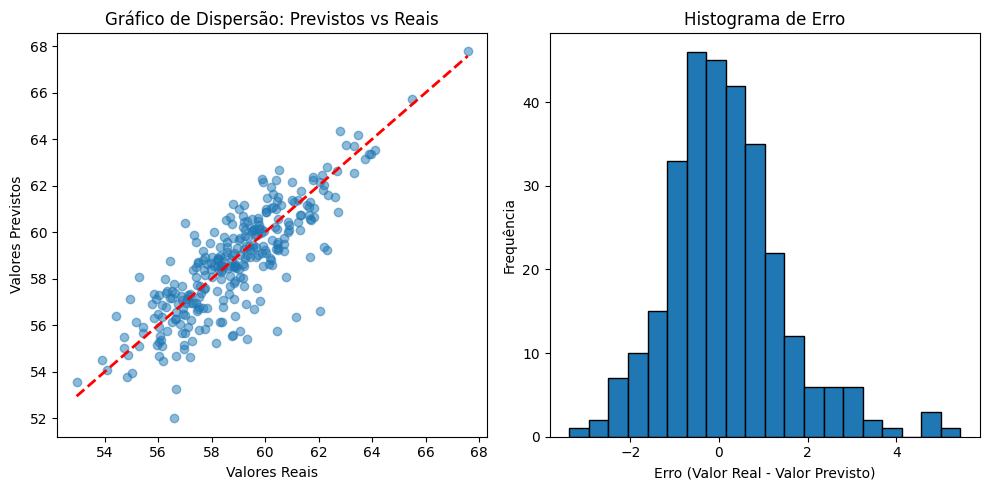

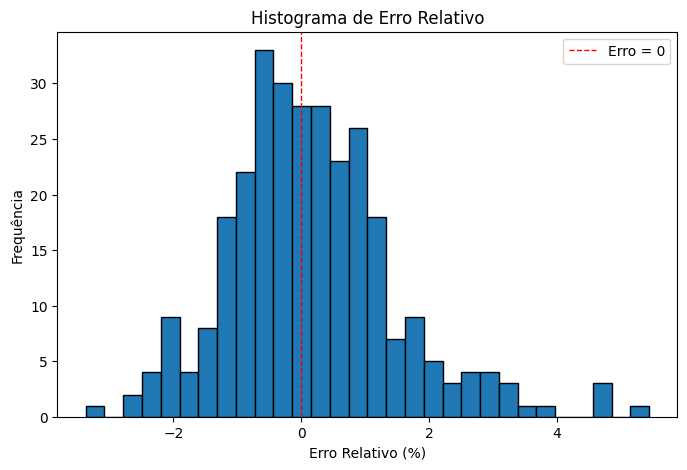

In [ ]:
plot_predictions_vs_actuals(l_real, l_pred)
plot_relative_errors(l_real, l_pred)

In [ ]:
# Selecionando elementos de y_pred onde o índice é par
b_pred = [y_pred[i] for i in range(len(y_pred)) if i % 2 == 0]

# Selecionando elementos de y_true onde o índice é ímpar
l_pred = [y_pred[i] for i in range(len(y_true)) if i % 2 != 0]

b_real = [y_true[i] for i in range(len(y_pred)) if i % 2 == 0]

# Selecionando elementos de y_true onde o índice é ímpar
l_real = [y_true[i] for i in range(len(y_true)) if i % 2 != 0]

In [ ]:
mae_b = mean_absolute_error(b_real, b_pred)
mse_b = mean_squared_error(b_real, b_pred)
r2_b = r2_score(b_real, b_pred)

mae_l = mean_absolute_error(l_real, l_pred)
mse_l = mean_squared_error(l_real, l_pred)
r2_l = r2_score(l_real, l_pred)
print("Métricas do modelo:")
print(f"MAE: {mae_b:.4f}")
print(f"MSE: {mse_b:.4f}")
print(f"R²: {r2_b:.4f}")

print("Métricas do modelo:")
print(f"MAE: {mae_l:.4f}")
print(f"MSE: {mse_l:.4f}")
print(f"R²: {r2_l:.4f}")

Métricas do modelo:
MAE: 0.7658
MSE: 1.0930
R²: 0.4785
Métricas do modelo:
MAE: 0.9929
MSE: 1.7707
R²: 0.6138
